# Movie recommendation system

First we need a data-set. For this we shall use the [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) available on kaggle. We will load it using Pandas. This dataset has two files tmdb_5000_credits.csv and tmdb_5000_movies.csv.

In [1]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('input/tmdb-movie-metadata/tmdb_5000_movies.csv')

The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:-

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column

In [2]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

we can view our data frames by running the following line of code.

In [4]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Filtering 
Data can be filtered based on many criterias. First is by giving each movie a score. This score can be calculated using a Weighted rating, which is obtained using a simple formula given as:
![weighted rating](images/wr.png)

where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We use this to counter the difference of number of ratings as a movie with a 8 average rating based on 5 ratings can't be considered better than a movie with a average rating of 7.5 based on 5000 ratings. **m** is thus used as a minimum threshold for a movie to be considered for recommendations.
We can obtain the mean average rating and thus obtian C. For the value of m we can pick any value but it should be aimed to give us best possible results so we will take 85th percentile i.e. it must have more ratings than 85% of the movies in the dataset.

In [3]:
C= df2['vote_average'].mean()
C

6.092171559442011

In [4]:
m= df2['vote_count'].quantile(0.85)
m

1300.6999999999998

Now using the values of C and m we will find all the movies that clear the threshold to be included and determine the weighted score for each using the formula decribed above.

In [5]:
v_movies = df2.copy().loc[df2['vote_count'] >= m]
v_movies.shape

(721, 23)

We have 721 valid movies in our dataset. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [6]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [7]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
v_movies['score'] = v_movies.apply(weighted_rating, axis=1)

Lets sort our data frames and see the top 10 movies list to see everything works fine.

In [8]:
#Sort movies based on score calculated above
v_movies = v_movies.sort_values('score', ascending=False)

#Print the top 15 movies
v_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.170528
662,Fight Club,9413,8.3,8.031958
3232,Pulp Fiction,8428,8.3,8.004820
65,The Dark Knight,12002,8.2,7.993903
3337,The Godfather,5893,8.4,7.982719
96,Inception,13752,8.1,7.926504
809,Forrest Gump,7927,8.2,7.902889
95,Interstellar,10867,8.1,7.885368
329,The Lord of the Rings: The Return of the King,8064,8.1,7.821125
1990,The Empire Strikes Back,5879,8.2,7.818138


Text(0.5, 1.0, 'Popular Movies')

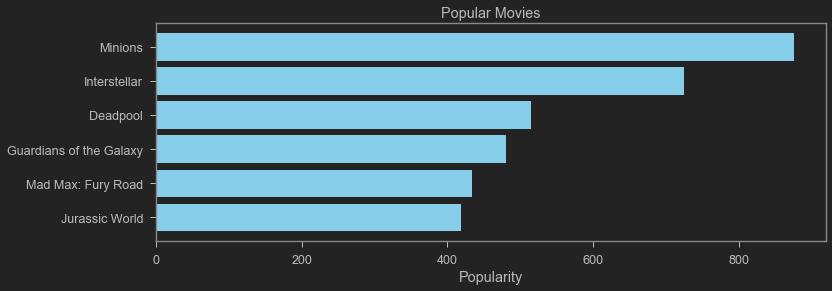

In [15]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

With a movie like minions topping the chart of popular movies it is clear that a simple popularity based system isn't enough so we will now use other filtering methods. 

# Content based filtering
1. Plot description based filtering
-Here we use the plot description of the movie to find similar movies. We have an overview plot summary for each movie in our dataset

In [16]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

In [9]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

We now need to determine the similarity between all the overviews. There are multiple methods to do so such as the euclidean, the Pearson and the cosine similarity scores. The decision for using any of these is case dependent a use full comparison of euclidean and cosine similarity can be found in this [article](https://medium.com/@sasi24/cosine-similarity-vs-euclidean-distance-e5d9a9375fc8).
We will be using the cosine similarity. It's formula is easy to understand and compute:
![cosine similarity](images/cosine.png)

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [10]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [11]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [12]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [14]:
get_recommendations('Interstellar')

1709         Space Pirate Captain Harlock
300                     Starship Troopers
4353                    The Green Inferno
220                            Prometheus
2260                      All Good Things
268                         Stuart Little
1352                              Gattaca
4176    Battle for the Planet of the Apes
2648                       Winnie Mandela
634                            The Matrix
Name: title, dtype: object

While the recommending system produces good results now, It's scope is limited. Since most non franchise movies may not match based on words used in overview. Like in our example above interstellar gave us mostly accurate recommendations but Stuart Little has no real association to interstellar. So we will also use the other metadata available to us like director, actors, genres along with the keywords from the plot description. These can be taken from our dataset and added to the dataframes using the folowing code.

In [15]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [16]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [17]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [18]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [19]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [20]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [21]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [22]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies.

In [23]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [24]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [25]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [28]:
get_recommendations('Interstellar', cosine_sim2)

270                      The Martian
2375                Midnight Special
363     A.I. Artificial Intelligence
1446                The Tree of Life
2752                      Ex Machina
3043                End of the Spear
3373        The Other Side of Heaven
3624                            Moon
39                      TRON: Legacy
43              Terminator Salvation
Name: title, dtype: object